# 1. Introduction

In this kernal we will make models to predict heart disease.
Let's start by detailing our steps 

1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

1. Look at the big picture

We will be classifying whether a person will have heart disease or not. We will have to get labeled health data from people who have and who have not had heart disease. So this is a suprvised learning, classification task. 


2. Getting the data

We will be using this data from a user on kaggle: https://www.kaggle.com/dileep070/heart-disease-prediction-using-logistic-regression

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier, LogisticRegression, Perceptron
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier,AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imb_Pipeline

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)
RANDOM_STATE = 42

In [2]:
DATA_PATH = '../input/heart-disease-prediction-using-logistic-regression/'
os.listdir(DATA_PATH)

['framingham.csv']

In [3]:
def load_data(health_path, filename):
    csv_path = os.path.join(health_path, filename)
    return pd.read_csv(csv_path)

# Load the CSVs
health_df = load_data(DATA_PATH, "framingham.csv")

In [4]:
# Let's see the size of our data
health_df.shape

(4238, 16)

In [5]:
# Let's take a look at the data
health_df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


This is what we know about the labels of the data.

Demographic:
* Sex: male or female(Nominal)
* Age: Age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)

Behavioral:

* Current Smoker: whether or not the patient is a current smoker (Nominal)
* Cigs Per Day: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarettes, even half a cigarette.)

Medical( history):
* BP Meds: whether or not the patient was on blood pressure medication (Nominal)
* Prevalent Stroke: whether or not the patient had previously had a stroke (Nominal)
* Prevalent Hyp: whether or not the patient was hypertensive (Nominal)
* Diabetes: whether or not the patient had diabetes (Nominal)

Medical(current):
* Tot Chol: total cholesterol level (Continuous)
* Sys BP: systolic blood pressure (Continuous)
* Dia BP: diastolic blood pressure (Continuous)
* BMI: Body Mass Index (Continuous)
* Heart Rate: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)
* Glucose: glucose level (Continuous)

Predict variable (desired target):
* 10 year risk of coronary heart disease CHD (binary: “1”, means “Yes”, “0” means “No”)

In [6]:
health_df = health_df.rename(columns={"male": "sex"})

In [7]:
health_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


We can see that the labels education, cigsPerDay, BPMeds, totChol, BMI, heartRate, and glucose all have missing data. 

In [8]:
# We can fill in the missing values with the column's median or mean
def fill_na_with_median(df, col):
    median = df[col].median() 
    return df[col].fillna(median), median

def fill_na_with_mean(df, col):
    mean = df[col].mean() 
    return df[col].fillna(mean), mean



In [9]:
# We also use an imputer to do the same thing
def fill_missing_values(df):
    imputer = SimpleImputer(strategy="median")
    imputer.fit(health_df)
    X = imputer.transform(health_df)
    health_tr = pd.DataFrame(X, columns=health_df.columns, index=health_df.index)
    return health_tr, imputer

health_tr, imputer = fill_missing_values(health_df)
health_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              4238 non-null   float64
 1   age              4238 non-null   float64
 2   education        4238 non-null   float64
 3   currentSmoker    4238 non-null   float64
 4   cigsPerDay       4238 non-null   float64
 5   BPMeds           4238 non-null   float64
 6   prevalentStroke  4238 non-null   float64
 7   prevalentHyp     4238 non-null   float64
 8   diabetes         4238 non-null   float64
 9   totChol          4238 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4238 non-null   float64
 13  heartRate        4238 non-null   float64
 14  glucose          4238 non-null   float64
 15  TenYearCHD       4238 non-null   float64
dtypes: float64(16)
memory usage: 529.9 KB


# 3. Discover and visualize the data to gain insights.

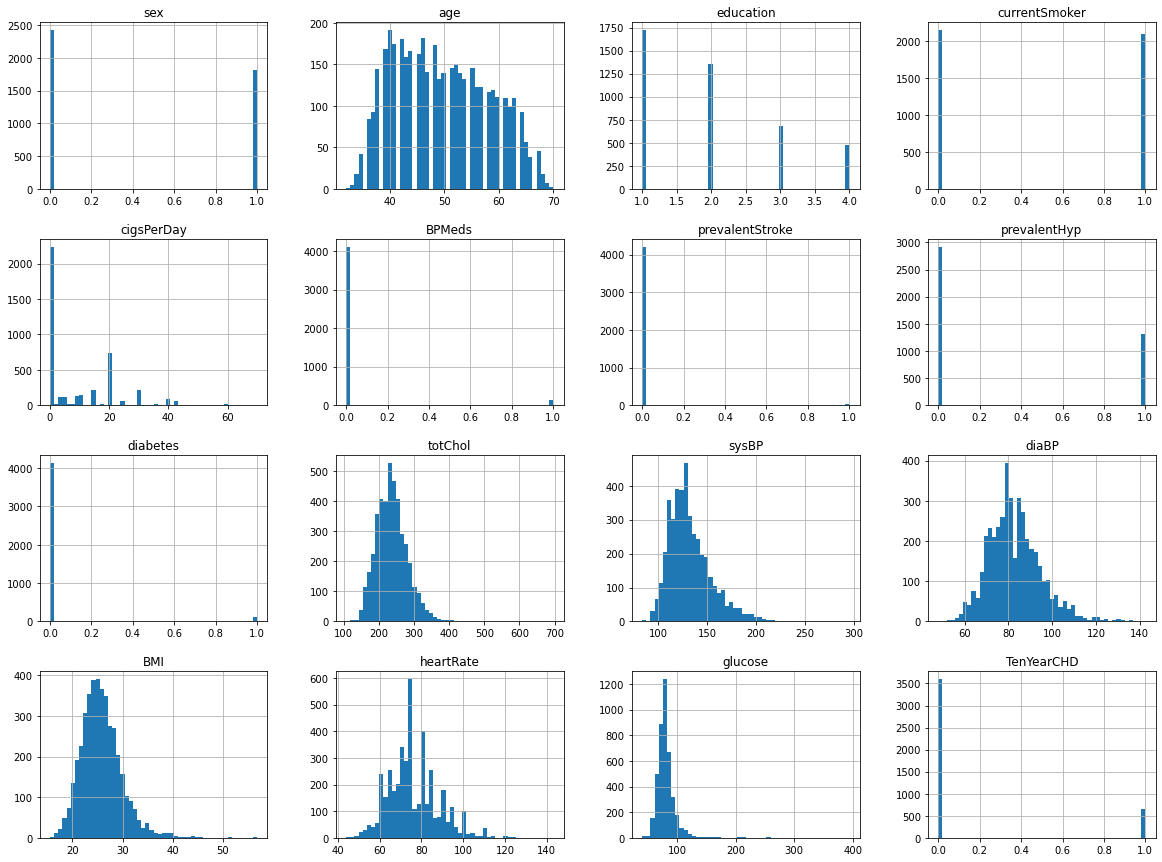

In [10]:
health_tr.hist(bins=50, figsize=(20,15))
plt.show()

Let's create a test set and put it aside for later.

In [11]:
# Creating a test set
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = train_test_split(health_tr, test_size=0.2,
random_state=RANDOM_STATE)


In [12]:
len(train_set)

3390

In [13]:
len(test_set)

848

In [14]:
# Feature Importance
X, y = train_set.drop('TenYearCHD', 1), train_set['TenYearCHD'].copy()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(X, y)
for name, score in zip(X.columns, rnd_clf.feature_importances_):
    print(name, score)

sex 0.01944018969689818
age 0.1258978855985549
education 0.03786703680944175
currentSmoker 0.012539630028308112
cigsPerDay 0.05358279555526568
BPMeds 0.007350783306491696
prevalentStroke 0.0037869392496798974
prevalentHyp 0.018137128669026566
diabetes 0.006269550895309774
totChol 0.12157351000501936
sysBP 0.1354925620367502
diaBP 0.11821304670830506
BMI 0.12706107851652246
heartRate 0.09709995396635135
glucose 0.11568790895807521


Let's also do stratified sampling based on the total cholesterol level category

In [15]:
health_tr["totChol"].describe()

count    4238.000000
mean      236.689476
std        44.327427
min       107.000000
25%       206.000000
50%       234.000000
75%       262.000000
max       696.000000
Name: totChol, dtype: float64

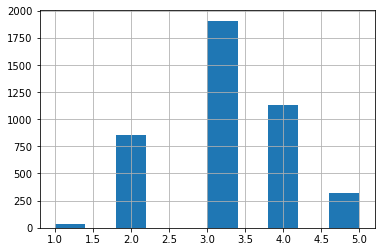

In [16]:
health_s = health_tr.copy()
health_s["totChol_cat"] = pd.cut(health_tr["totChol"], 
                               bins=[100, 150, 200, 250, 300, np.inf], 
                               labels=[1, 2, 3, 4, 5])

health_s["totChol_cat"].hist()



In [17]:

def strat_split(df, col):
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(df, df[col]):
        strat_train_set = df.loc[train_index]
        strat_test_set = df.loc[test_index]
    return strat_train_set, strat_test_set


strat_train_set, strat_test_set = strat_split(health_s, 'totChol_cat')

In [18]:
strat_test_set["totChol_cat"].value_counts() / len(strat_test_set)

3    0.449292
4    0.265330
2    0.201651
5    0.075472
1    0.008255
Name: totChol_cat, dtype: float64

We will use this later.

# 4. Prepare the data for Machine Learning algorithms.

## Feature Scaling with standardization
Let's scale to features for our model. We can create a pipeline to do both deature scaling, and replacing missing values

In [19]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler()),
    ])

num_pipeline.fit_transform(health_df.drop('TenYearCHD', 1))

array([[ 1.1531919 , -1.23495068,  2.00655919, ...,  0.28737925,
         0.34276147, -0.2013593 ],
       [-0.86715836, -0.41825733,  0.02038662, ...,  0.7197521 ,
         1.59029076, -0.24509896],
       [ 1.1531919 , -0.18491638, -0.97269966, ..., -0.11305697,
        -0.07308163, -0.5075369 ],
       ...,
       [-0.86715836, -0.18491638,  0.02038662, ..., -0.93358273,
         0.67543595,  0.19229761],
       [-0.86715836, -0.65159829, -0.97269966, ..., -1.63127529,
         0.84177318, -0.15761964],
       [-0.86715836,  0.28176554,  0.02038662, ..., -1.06378592,
         0.34276147,  1.11083042]])

In [20]:
def prepare_features(df):
    X = df.drop('TenYearCHD', 1)
    y = df['TenYearCHD'].copy()
    X = num_pipeline.transform(X)
    return X, y

X_train, y_train = prepare_features(train_set)
X_test, y_test = prepare_features(test_set)

# 5. Select a model and train it.

For our base model, we will use stochastic gradient descent model.

In [21]:
sgd_clf = SGDClassifier(random_state=RANDOM_STATE)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [22]:
y_pred = sgd_clf.predict(X_test)
sum(y_pred == y_test)/len(y_pred)

0.8573113207547169

In [23]:
scores = cross_val_score(sgd_clf, X_train, y_train, scoring="accuracy", cv=3)
scores

array([0.8380531 , 0.81681416, 0.83716814])

That seems good, but let's try a classifier that only returns negatives. 

In [24]:
class AlwayNegativeClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
always_negative_clf = AlwayNegativeClassifier()
cross_val_score(always_negative_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.85221239, 0.84247788, 0.84513274])

We now see that our model is not doing the best.

## Confusion Matrix
Let's use a confusion matrix to evaluate the performance of our classifier.

In [25]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [26]:
confusion_matrix(y_train, y_train_pred)

array([[2785,   85],
       [ 489,   31]])

2785 true negatives, 85 false postives, 489 false negatives, and 31 true postives. The classifier is not classifiying positives that much. 

In [27]:
# TP/(TP+FP)
precision_score(y_train, y_train_pred)

0.2672413793103448

26.7% rate of predicting someone has a heart disease

In [28]:
# TP/(TP+FN)
recall_score(y_train, y_train_pred)

0.05961538461538462

Only detects 5.9% of people with heart disease

F-Score

In [29]:
f1_score(y_train, y_train_pred)

0.09748427672955975

In [30]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91      2870
         1.0       0.27      0.06      0.10       520

    accuracy                           0.83      3390
   macro avg       0.56      0.51      0.50      3390
weighted avg       0.76      0.83      0.78      3390



In [31]:
def report_model_score(model, X, y):
    y_pred = cross_val_predict(model, X, y, cv=3)
    print('Confusion Matrix: \n', confusion_matrix(y, y_pred))
    print('\nAccuracy Score: \n', accuracy_score(y, y_pred))
    print('\nROC AUC: \n', roc_auc_score(y, y_pred))
    print('\nReport: \n', classification_report(y,y_pred))


report_model_score(sgd_clf, X_train, y_train,)

Confusion Matrix: 
 [[2785   85]
 [ 489   31]]

Accuracy Score: 
 0.8306784660766962

ROC AUC: 
 0.5149993299383543

Report: 
               precision    recall  f1-score   support

         0.0       0.85      0.97      0.91      2870
         1.0       0.27      0.06      0.10       520

    accuracy                           0.83      3390
   macro avg       0.56      0.51      0.50      3390
weighted avg       0.76      0.83      0.78      3390



Let's try some other classifiers.

In [32]:
lr_clf = LogisticRegression(random_state=RANDOM_STATE)
report_model_score(lr_clf, X_train, y_train)

Confusion Matrix: 
 [[2847   23]
 [ 474   46]]

Accuracy Score: 
 0.8533923303834808

ROC AUC: 
 0.5402238005896541

Report: 
               precision    recall  f1-score   support

         0.0       0.86      0.99      0.92      2870
         1.0       0.67      0.09      0.16       520

    accuracy                           0.85      3390
   macro avg       0.76      0.54      0.54      3390
weighted avg       0.83      0.85      0.80      3390



In [33]:
rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)
report_model_score(rf_clf, X_train, y_train)

Confusion Matrix: 
 [[2840   30]
 [ 488   32]]

Accuracy Score: 
 0.8471976401179941

ROC AUC: 
 0.5255427499329939

Report: 
               precision    recall  f1-score   support

         0.0       0.85      0.99      0.92      2870
         1.0       0.52      0.06      0.11       520

    accuracy                           0.85      3390
   macro avg       0.68      0.53      0.51      3390
weighted avg       0.80      0.85      0.79      3390



In [34]:
# Decision Tree
dt_clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
report_model_score(dt_clf, X_train, y_train)

Confusion Matrix: 
 [[2480  390]
 [ 389  131]]

Accuracy Score: 
 0.7702064896755162

ROC AUC: 
 0.5580172875904583

Report: 
               precision    recall  f1-score   support

         0.0       0.86      0.86      0.86      2870
         1.0       0.25      0.25      0.25       520

    accuracy                           0.77      3390
   macro avg       0.56      0.56      0.56      3390
weighted avg       0.77      0.77      0.77      3390



In [35]:
# KNeighbors
kn_clf = KNeighborsClassifier()
report_model_score(kn_clf, X_train, y_train)

Confusion Matrix: 
 [[2782   88]
 [ 471   49]]

Accuracy Score: 
 0.8351032448377581

ROC AUC: 
 0.531784374162423

Report: 
               precision    recall  f1-score   support

         0.0       0.86      0.97      0.91      2870
         1.0       0.36      0.09      0.15       520

    accuracy                           0.84      3390
   macro avg       0.61      0.53      0.53      3390
weighted avg       0.78      0.84      0.79      3390



In [36]:
gnb_clf = GaussianNB()
report_model_score(gnb_clf, X_train, y_train)

Confusion Matrix: 
 [[2683  187]
 [ 408  112]]

Accuracy Score: 
 0.8244837758112095

ROC AUC: 
 0.5751139104797641

Report: 
               precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      2870
         1.0       0.37      0.22      0.27       520

    accuracy                           0.82      3390
   macro avg       0.62      0.58      0.59      3390
weighted avg       0.79      0.82      0.80      3390



In [37]:
# SVC
svc_clf = SVC(random_state=RANDOM_STATE)
report_model_score(svc_clf, X_train, y_train)

Confusion Matrix: 
 [[2863    7]
 [ 515    5]]

Accuracy Score: 
 0.8460176991150442

ROC AUC: 
 0.5035881801125703

Report: 
               precision    recall  f1-score   support

         0.0       0.85      1.00      0.92      2870
         1.0       0.42      0.01      0.02       520

    accuracy                           0.85      3390
   macro avg       0.63      0.50      0.47      3390
weighted avg       0.78      0.85      0.78      3390



### Balance Training Data
Let's see if we can improve our models by balancing our data. 

In [38]:
def balance_data(df, col):
    X = df.drop(col, 1)
    y = df[col]
    
    pipeline = imb_Pipeline([('over', SMOTE()),
                             ('under', RandomUnderSampler())])
    
    X, y = pipeline.fit_resample(X, y)
    X = num_pipeline.transform(X)
    return X, y

X_train_b, y_train_b = balance_data(train_set, 'TenYearCHD')

In [39]:
sgd_clf = SGDClassifier(random_state=RANDOM_STATE)
report_model_score(sgd_clf, X_train_b, y_train_b)

Confusion Matrix: 
 [[1731 1139]
 [ 898 1972]]

Accuracy Score: 
 0.6451219512195122

ROC AUC: 
 0.6451219512195122

Report: 
               precision    recall  f1-score   support

         0.0       0.66      0.60      0.63      2870
         1.0       0.63      0.69      0.66      2870

    accuracy                           0.65      5740
   macro avg       0.65      0.65      0.64      5740
weighted avg       0.65      0.65      0.64      5740



In [40]:
lr_clf = LogisticRegression(random_state=RANDOM_STATE)
report_model_score(lr_clf, X_train_b, y_train_b)

Confusion Matrix: 
 [[1925  945]
 [ 888 1982]]

Accuracy Score: 
 0.6806620209059233

ROC AUC: 
 0.6806620209059233

Report: 
               precision    recall  f1-score   support

         0.0       0.68      0.67      0.68      2870
         1.0       0.68      0.69      0.68      2870

    accuracy                           0.68      5740
   macro avg       0.68      0.68      0.68      5740
weighted avg       0.68      0.68      0.68      5740



In [41]:
rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)
report_model_score(rf_clf, X_train_b, y_train_b)

Confusion Matrix: 
 [[2685  185]
 [ 349 2521]]

Accuracy Score: 
 0.9069686411149825

ROC AUC: 
 0.9069686411149825

Report: 
               precision    recall  f1-score   support

         0.0       0.88      0.94      0.91      2870
         1.0       0.93      0.88      0.90      2870

    accuracy                           0.91      5740
   macro avg       0.91      0.91      0.91      5740
weighted avg       0.91      0.91      0.91      5740



91% looks good, lets test our model on the test set.

In [42]:
rf_clf.fit(X_train_b, y_train_b)
rf_clf.score(X_test, y_test)

0.8290094339622641

It performed worse with the balanced data. 

In [43]:
lr_clf.fit(X_train_b, y_train_b)
lr_clf.score(X_test, y_test)

0.6367924528301887

## Ensemble Learning

In [44]:
sgd_clf = SGDClassifier(random_state=RANDOM_STATE)
gnb_clf = GaussianNB() 
kn_clf = KNeighborsClassifier()
log_clf = LogisticRegression(random_state=RANDOM_STATE)
rnd_clf = RandomForestClassifier(random_state=RANDOM_STATE)
svm_clf = SVC(random_state=RANDOM_STATE)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf),
                ('sgd', sgd_clf), ('gnb', gnb_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42)),
                             ('sgd', SGDClassifier(random_state=42)),
                             ('gnb', GaussianNB())])

In [45]:
for clf in (log_clf, rnd_clf, svm_clf, sgd_clf, gnb_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8573113207547169
RandomForestClassifier 0.8502358490566038
SVC 0.8549528301886793
SGDClassifier 0.8573113207547169
GaussianNB 0.8242924528301887
VotingClassifier 0.8549528301886793


### Bagging and Pasting

In [46]:
def bagging_model(model, n_estimators=500, max_samples=250):
    bag_clf = BaggingClassifier(model, n_estimators=n_estimators, 
                            max_samples=max_samples, bootstrap=True, n_jobs=-1)
    bag_clf.fit(X_train, y_train)
    y_pred = bag_clf.predict(X_test)
    #print('OOB score:', bag_clf.oob_score_)
    print('Accuracy score:', accuracy_score(y_test, y_pred))
    return bag_clf

In [47]:
bagging_model(DecisionTreeClassifier())

Accuracy score: 0.8549528301886793


BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=250,
                  n_estimators=500, n_jobs=-1)

In [48]:
bagging_model(LogisticRegression())

Accuracy score: 0.8584905660377359


BaggingClassifier(base_estimator=LogisticRegression(), max_samples=250,
                  n_estimators=500, n_jobs=-1)

In [49]:
bagging_model(SVC())

Accuracy score: 0.8537735849056604


BaggingClassifier(base_estimator=SVC(), max_samples=250, n_estimators=500,
                  n_jobs=-1)

### Boosting

In [50]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)
ada_clf.predict(X_test)
print('Accuracy score:', accuracy_score(y_test, y_pred))

Accuracy score: 0.8549528301886793


In [51]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                 max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8419811320754716

### Deep Learning

In [52]:

per_clf = Perceptron()
per_clf.fit(X_train, y_train)

Perceptron()

In [53]:
per_clf.score(X_test, y_test)

0.7464622641509434

In [54]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=[1, 15]),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
    ])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=1)
test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/10
3390/3390 [==============================] - 3s 990us/step - loss: 0.4134 - accuracy: 0.8475
Epoch 2/10
3390/3390 [==============================] - 3s 1ms/step - loss: 0.3914 - accuracy: 0.8499
Epoch 3/10
3390/3390 [==============================] - 3s 1ms/step - loss: 0.3839 - accuracy: 0.8516
Epoch 4/10
3390/3390 [==============================] - 3s 1ms/step - loss: 0.3803 - accuracy: 0.8501
Epoch 5/10
3390/3390 [==============================] - 3s 1ms/step - loss: 0.3765 - accuracy: 0.8522
Epoch 6/10
3390/3390 [==============================] - 3s 996us/step - loss: 0.3755 - accuracy: 0.8522
Epoch 7/10
3390/3390 [==============================] - 3s 1ms/step - loss: 0.3730 - accuracy: 0.8528
Epoch 8/10
3390/3390 [==============================] - 3s 1ms/step - loss: 0.3712 - accuracy: 0.8540
Epoch 9/10
3390/3390 [==============================] - 3s 1ms/step - loss: 0.3699 - accuracy: 0.8510
Epoch 10/10
27/27 [==============================] - 0s 1ms/step - loss: 0.386

6. Fine-tune your model.

7. Present your solution.

In [55]:
lr = LogisticRegression(random_state=RANDOM_STATE)
report_model_score(lr, X_train, y_train)

Confusion Matrix: 
 [[2847   23]
 [ 474   46]]

Accuracy Score: 
 0.8533923303834808

ROC AUC: 
 0.5402238005896541

Report: 
               precision    recall  f1-score   support

         0.0       0.86      0.99      0.92      2870
         1.0       0.67      0.09      0.16       520

    accuracy                           0.85      3390
   macro avg       0.76      0.54      0.54      3390
weighted avg       0.83      0.85      0.80      3390



In [56]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8573113207547169

8. Launch, monitor, and maintain your system.

In [57]:
# save the classifier
with open('heart_disease_classifier.pkl', 'wb') as fid:
    pickle.dump(lr, fid)

# References
* [1] Aurelien Geron, Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems